# Image inpainting over CIFAR-10

The purpose of this project is to build and train a neural network for image inpainting over the CIFAR-10 dataset. 

Inpainting is a restauration process where damaged, deteriorated, or missing parts of an artwork are filled in to present a complete image.

In our case, we create the portion of the image to be filled in by cropping a fixed size rectangular area from CIFAR-10 images.

The networks must be trained over the training set, and tested on the test set.
You can split the train set into a validation set, if you wish.

The metrics that will be used to evaluate you result is Mean Square Error.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from tensorflow.keras import layers, models, metrics
from tensorflow.keras.datasets import cifar10

Here we load the dataset.

In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print("image range is {}, {}".format(np.min(x_test,axis=(0,1,2,3)),np.max(x_test,axis=(0,1,2,3))))
x_train = (x_train/255.).astype(np.float32)
x_test = (x_test/255.).astype(np.float32)
print("new image range is {}, {}".format(np.min(x_test,axis=(0,1,2,3)),np.max(x_test,axis=(0,1,2,3))))

170498071/170498071 [==============================] - 6s 0us/step
image range is 0, 255
new image range is 0.0, 1.0


Let's see some examples.

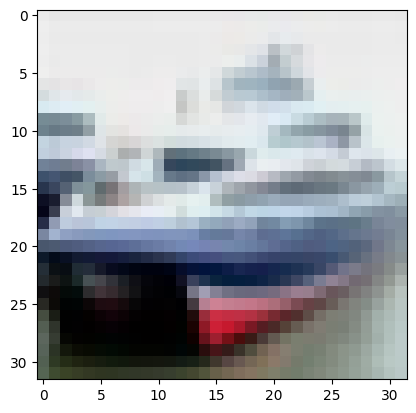

In [4]:
plt.imshow(x_test[1])
plt.show()

Now we hide a portion of the input, and the purpose of the network is to reconstruct it.

In [5]:
def mask(X,coords):
  x0,y0,x1,y1 = coords
  X[:,x0:x1,y0:y1] = 0
  return X

masked_x_train = mask(np.copy(x_train),(2,16,30,30))
masked_x_test = mask(np.copy(x_test),(2,16,30,30))

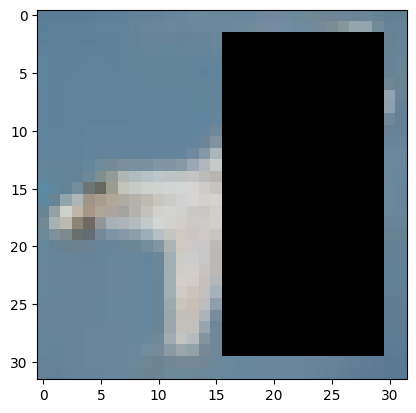

In [7]:
plt.imshow(masked_x_test[10])
plt.show()

# Approaches and evaluation

The network is supposed to take in input the masked image and fill in the missing part. 

You may basically follow two main approaches:
*   either you return the full image
*   you just return the missing crop

In the first case, the mse is to be evaluated on the full image; in the second case just on the crop (since on the reamining part is 0). 

If you want to take a different approach, you can ask for my approuval.



# What to deliver

As usual, you are supposed to deliver a single notebook comprising the code, the training history, and the evaluation on test data in terms of Mean Square Error.

Good work!

# Model
We use Generative Adversarial Networks (GANs) to perform image inpainting on CIFAR10. GANs are composed of two neural networks: a generator and a discriminator. The generator tries to create realistic images that match the input image except for the masked parts, while the discriminator tries to distinguish between real and fake images. The generator and the discriminator compete with each other and improve each other’s performance.

We use GANs for image inpainting because they can generate realistic and diverse results that preserve both global and local features of the image. They can also handle irregular and large masks that may be difficult for other methods. GANs are also flexible and can be adapted to different datasets and tasks.

We implement GANs on Keras, a high-level deep learning framework. We use an encoder-decoder architecture for the generator and a convolutional network for the discriminator. We train the GAN model with binary crossentropy loss and Adam optimizer. We use callbacks to save the generated images after each epoch and to stop training when there are no more improvements.

We evaluate the GAN model by visually inspecting the generated images and comparing them with the original images. We also use quantitative metrics such as peak signal-to-noise ratio (PSNR) and structural similarity index (SSIM) to measure the quality of the inpainted images.

In [30]:
# Import Keras modules
from tensorflow.keras import Model
from tensorflow.keras import optimizers
from tensorflow.keras import Sequential


# Define a function to create a GAN model in Keras
def createGAN(input_size):
    # Define the generator model
    generator = Sequential(
        [
            # Start with an input layer that takes the image as input
            layers.InputLayer(input_shape=input_size),
            # Convolutional layer with 64 filters and 4x4 kernel
            layers.Conv2D(64, (4, 4), strides=(2, 2), padding="same"),
            layers.LeakyReLU(alpha=0.2),
            # Convolutional layer with 128 filters and 4x4 kernel
            layers.Conv2D(128, (4, 4), strides=(2, 2), padding="same"),
            layers.LeakyReLU(alpha=0.2),
            # Flatten the output
            layers.Flatten(),
            # Dense layer that maps the flattened output to a random noise vector of size 16384
            layers.Dense(16384),
            # Reshape the noise vector to a 8x8x256 tensor
            layers.Reshape((8, 8, 256)),
            # Upsample to 16x16
            layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding="same", use_bias=False),
            layers.BatchNormalization(),
            layers.LeakyReLU(),
            # Upsample to 32x32
            layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding="same", use_bias=False),
            layers.BatchNormalization(),
            layers.LeakyReLU(),
            # Output layer with tanh activation
            layers.Conv2DTranspose(3, (5, 5), strides=(1, 1), padding="same", use_bias=False, activation="tanh"),
        ],
        name="generator",
    )

    # Define the discriminator model
    discriminator = Sequential(
        [
            # Input layer with 32x32x3 images
            layers.InputLayer(input_shape=(32, 32, 3)),
            # Convolutional layer with 64 filters and 4x4 kernel
            layers.Conv2D(64, (4, 4), strides=(2, 2), padding="same"),
            layers.LeakyReLU(alpha=0.2),
            # Convolutional layer with 128 filters and 4x4 kernel
            layers.Conv2D(128, (4, 4), strides=(2, 2), padding="same"),
            layers.LeakyReLU(alpha=0.2),
            # Flatten the output
            layers.Flatten(),
            # Output layer with sigmoid activation
            layers.Dense(1, activation="sigmoid"),
        ],
        name="discriminator",
    )

    # Define the GAN model
    gan = Sequential([generator, discriminator])

    # Compile the GAN model with MSE loss and Adam optimizer
    gan.compile(loss="mean_squared_error", optimizer=optimizers.Adam(learning_rate=0.0002, beta_1=0.5))

    # Return the GAN model
    return gan


## Training


In [34]:
from tensorflow.keras.callbacks import Callback
epochs=10
batch_size=32
input_size=(32,32,3)

# Create a GAN model using the function defined earlier
gan = createGAN(input_size)

# Get the generator and the discriminator from the GAN model
generator, discriminator = gan.layers

# Make the discriminator untrainable when updating the generator
discriminator.trainable = False

# Define a callback to stop training when there are no more improvements
class EarlyStopping(Callback):
  def __init__(self, patience):
    self.patience = patience # Number of epochs with no improvement to stop training
    self.best_loss = np.inf # Best loss value so far
    self.wait = 0 # Number of epochs with no improvement so far

  def on_epoch_end(self, epoch, logs=None):
    # Get the current loss value
    current_loss = logs.get("loss")
    # Check if it is lower than the best loss value
    if current_loss < self.best_loss:
      # Update the best loss value and reset the wait counter
      self.best_loss = current_loss
      self.wait = 0
    else:
      # Increment the wait counter
      self.wait += 1
      # Check if the wait counter exceeds the patience value
      if self.wait >= self.patience:
        # Stop training and restore the best weights
        print(f"\nEpoch {epoch}: early stopping")
        self.model.stop_training = True
        self.model.set_weights(self.best_weights)

  def on_train_begin(self, logs=None):
    # Initialize the best weights at the start of training
    self.best_weights = self.model.get_weights()

# Create instances of the callbacks
early_stopping = EarlyStopping(patience=10)

# Train the GAN model with the CIFAR10 dataset and the callbacks
gan.fit(x_train, y_train,epochs=epochs, batch_size=batch_size)#, callbacks=[gan_monitor, early_stopping])

Epoch 1/10
1563/1563 [==============================] - 76s 40ms/step - loss: 20.5034
Epoch 2/10
1563/1563 [==============================] - 62s 39ms/step - loss: 20.5000
Epoch 3/10
1563/1563 [==============================] - 62s 39ms/step - loss: 20.5000
Epoch 4/10
1563/1563 [==============================] - 61s 39ms/step - loss: 20.5000
Epoch 5/10
1563/1563 [==============================] - 61s 39ms/step - loss: 20.5000
Epoch 6/10
1563/1563 [==============================] - 61s 39ms/step - loss: 20.5000
Epoch 7/10
1563/1563 [==============================] - 60s 39ms/step - loss: 20.5000
Epoch 8/10
1563/1563 [==============================] - 60s 39ms/step - loss: 20.5000
Epoch 9/10
1563/1563 [==============================] - 60s 38ms/step - loss: 20.5000
Epoch 10/10
1563/1563 [==============================] - 62s 39ms/step - loss: 20.5000


# Testing


In [53]:
# Add a batch dimension to the image
image = np.expand_dims(masked_x_test[10], axis=0)

# Predict a fake image from the generator model
pred = generator.predict(image)
print(pred.shape)

1/1 [==============================] - 0s 30ms/step
(1, 32, 32, 3)


Text(0.5, 1.0, 'generated image')

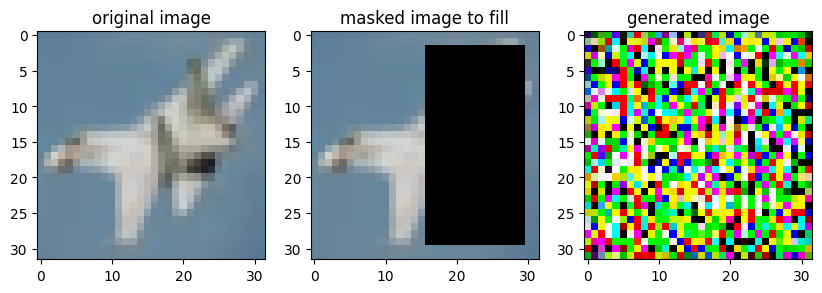

In [55]:
plt.figure(figsize=(10,5))

plt.subplot(1,3,1)
plt.imshow(x_test[10])
plt.title("original image")

plt.subplot(1,3,2)
plt.imshow(masked_x_test[10])
plt.title("masked image to fill")

plt.subplot(1,3,3)
plt.imshow(pred[0])
plt.title("generated image")
